# 20240822分析正负先导的发展特征

In [200]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy import stats
import numpy as np
import pandas as pd
from pandas import DataFrame

## 定义绘图函数

### 2d绘图

In [201]:
def plot_2d_result(results:DataFrame,start_loc:int, end_loc:int):
    # 提取数据
    azimuth = results['Azimuth']
    elevation = results['Elevation']
    # 设置图形背景为白色
    plt.figure(facecolor='white')
    # 绘制单色散点图
    plt.scatter(azimuth, elevation, 
                s=2,  # 点大小
                color='black',  # 单色设置
                alpha=0.8,  # 透明度
                marker='o')  # 点样式
    
    # 设置标题和轴标签（深色文字）
    plt.title(f'{start_loc:.3e} - {end_loc:.3e} : {len(azimuth)} points', fontsize=16, fontweight='bold', color='black')
    plt.xlabel('Azimuth / °', fontsize=12, color='black')
    plt.ylabel('Elevation / °', fontsize=12, color='black')
    
    # 设置坐标轴范围和刻度
    # plt.xlim(250 , 300)
    # plt.xticks(range(250, 301, 10))  # 250到300，间隔10
    # plt.ylim(55, 80)
    # plt.yticks(range(55, 81, 5))  # 55到85，间隔5
    # 调整布局并显示
    plt.tight_layout()
    plt.show()

### 3d绘图

## 定义计算梯级间隔函数

In [202]:
def cal_step_interval(results:DataFrame,start_loc:int, end_loc:int, thea:int = 3000 ):
    time_diffs = np.diff(results.Start_loc)
    max_diff_idx = np.argmax(time_diffs)
    corresponding_start_loc = results.Start_loc.iloc[max_diff_idx]
    print("最大的间隔位于:", corresponding_start_loc)
    # 查看时间间隔大于某阈值的个数
    filtered_positive_time_diffs = time_diffs[time_diffs > thea] * 5 / 1e3
    print(f"时间间隔大于{thea}的个数有：{len(filtered_positive_time_diffs)}")
    print(f"信号位置 {start_loc}-{end_loc} 阶段的时间间隔分布情况：\n",
          pd.DataFrame(data=filtered_positive_time_diffs).describe())

## 定义计算梯级持续时间的函数

In [203]:
def cal_step_duration(results:DataFrame,start_loc:int, end_loc:int, thea:int = 3000):
    time_diffs = np.diff(results.Start_loc)
    filtered_indices = np.where(time_diffs > thea)
    filtered_start_loc = results.Start_loc.iloc[filtered_indices[0]].values    # .values 将结果转为Numpy数组
    start_locs = filtered_start_loc[:-1]  # 去掉最后一个元素
    end_locs = filtered_start_loc[1:]    # 去掉第一个元素
    # 拼接为元组列表
    loc_tuples = list(zip(start_locs, end_locs))
    durations = []
    for i, loc_tuple in enumerate(loc_tuples):
        durations.append((loc_tuple[1]-loc_tuple[0])*5/1e3)
    durations_df = pd.DataFrame(data=durations)
    print(f"信号位置 {start_loc}-{end_loc} 阶段的梯级持续时间分布情况：\n",durations_df.describe())       

## 定义计算梯级步长的函数

In [274]:
import warnings
warnings.filterwarnings("ignore", message="One or more sample arguments is too small; all returned values will be NaN.")
def cal_step_distances(results_2d:DataFrame,results_3d:DataFrame,start_loc:int, end_loc:int, epsilon:int = 300, min_samples:int = 3, thea:int = 3000):
    # Step1: 拿到每个间隔对应的位置范围
    time_diffs = np.diff(results_2d.Start_loc)
    filtered_indices = np.where(time_diffs > thea)
    filtered_start_loc = results_2d.Start_loc.iloc[filtered_indices[0]].values    # .values 将结果转为Numpy数组
    start_locs = filtered_start_loc[:-1]  # 去掉最后一个元素
    end_locs = filtered_start_loc[1:]    # 去掉第一个元素
    # 拼接为元组列表
    loc_tuples = list(zip(start_locs, end_locs))
    distances = []
    # Step2: 三维结果中筛选出对应的结果
    for i, loc_tuple in enumerate(loc_tuples):
        # 按时间范围筛选结果
        filtered_loc_3d_result = results_3d[
            (results_3d.yld_start_loc > loc_tuple[0] - 1) &
            (results_3d.yld_start_loc < loc_tuple[1] + 1)
        ]
        if len(filtered_loc_3d_result) > min_samples:
            points_in_window = filtered_loc_3d_result[['x', 'y', 'z']].values
            db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(points_in_window)
            cluster_labels = db.labels_
            core_samples_labels = cluster_labels[cluster_labels != -1]
            # 找到出现次数最多的簇ID
            main_cluster_id = stats.mode(core_samples_labels).mode
            main_path_mask = (cluster_labels == main_cluster_id)
            if np.sum(main_path_mask) < 2:
                continue
            # 使用掩码从DataFrame中获取主路径的所有数据
            main_path_df = filtered_loc_3d_result[main_path_mask]
            # 对筛选出的主路径点，按时间重新排序
            main_path_sorted_df = main_path_df.sort_values(by='yld_start_loc')
            # 获取并输出主路径的起止位置
            #    .iloc[0] 获取第一行, .iloc[-1] 获取最后一行
            start_position = main_path_sorted_df.iloc[0][['x','y','z']].values
            end_position = main_path_sorted_df.iloc[-1][['x','y','z']].values
            # Step3: 计算三维距离（步长）
            distance = np.linalg.norm(end_position-start_position)
            if distance > 1:
                distances.append(distance)
        
    distances_df = pd.DataFrame(data=distances)
    print(f"信号位置 {start_loc}-{end_loc} 阶段的梯级步长分布情况：\n",distances_df.describe())        

## 1.加载二维、三维的结果

In [205]:
three_d_result = pd.read_csv("../two_station_3D/results/3d_win512_cost_cal_yld_chj_dtoa_3.6e8_5.6e8.csv")

filtered_3d_result = three_d_result[
    (three_d_result.dlta < 20000) & 
    (three_d_result.yld_start_loc > 3.65e8) & 
    (three_d_result.yld_start_loc < 4e8) & 
    (three_d_result.r_gccs > 0.1) & 
    (abs(three_d_result.R3_value) < 10000) & 
    (three_d_result.x < 6000) & 
    (three_d_result.x > -10000) & 
    (three_d_result.y < 0) & 
    (three_d_result.y > -10000) & 
    (three_d_result.z < 9000) & 
    (three_d_result.z > 500)
]

# 加载2d定位结果数据
two_d_result = pd.read_csv('results/20240822165932_result_yld_3.6e8_5.6e8_window_1024_256_阈值4倍标准差_去零飘_30_80_hann.txt', sep=r'\s+')

## 2. 根据结果的高度，对闪电进行分段

In [206]:
filtered_height_3d_result = filtered_3d_result[
    (filtered_3d_result.z > 5000 ) & (filtered_3d_result.z < 6000 ) &
    (filtered_3d_result.yld_start_loc > 3.65e8 ) & (filtered_3d_result.yld_start_loc < 3.66e8 )
]
filtered_height_3d_result.yld_start_loc.describe()

count    5.210000e+02
mean     3.657387e+08
std      8.242826e+04
min      3.656194e+08
25%      3.656770e+08
50%      3.657219e+08
75%      3.657872e+08
max      3.659817e+08
Name: yld_start_loc, dtype: float64

In [207]:
filtered_height_3d_result = filtered_3d_result[
    (filtered_3d_result.z > 3500 ) & (filtered_3d_result.z < 5000 ) &
    (filtered_3d_result.yld_start_loc > 3.66e8 ) & (filtered_3d_result.yld_start_loc < 3.68e8 )
]
filtered_height_3d_result.yld_start_loc.describe()

count    5.520000e+02
mean     3.669599e+08
std      4.924984e+05
min      3.660074e+08
25%      3.665891e+08
50%      3.669481e+08
75%      3.673355e+08
max      3.679729e+08
Name: yld_start_loc, dtype: float64

In [208]:
filtered_height_3d_result = filtered_3d_result[
    (filtered_3d_result.z > 2000 ) & (filtered_3d_result.z < 3500 ) &
    (filtered_3d_result.yld_start_loc > 3.68e8 ) & (filtered_3d_result.yld_start_loc < 3.70e8 )
]
filtered_height_3d_result.yld_start_loc.describe()

count    9.620000e+02
mean     3.689841e+08
std      5.342078e+05
min      3.680006e+08
25%      3.685316e+08
50%      3.689227e+08
75%      3.694455e+08
max      3.699985e+08
Name: yld_start_loc, dtype: float64

In [209]:
filtered_height_3d_result = filtered_3d_result[
    (filtered_3d_result.z > 500 ) & (filtered_3d_result.z < 2000 ) &
    (filtered_3d_result.yld_start_loc > 3.7e8 ) & (filtered_3d_result.yld_start_loc < 3.72e8 )
]
filtered_height_3d_result.yld_start_loc.describe()

count    1.034000e+03
mean     3.708391e+08
std      4.742866e+05
min      3.700021e+08
25%      3.704228e+08
50%      3.707753e+08
75%      3.712198e+08
max      3.719662e+08
Name: yld_start_loc, dtype: float64

## 3. 计算负先导的梯级个数、梯级间隔、梯级步长

### 5500-7000高度

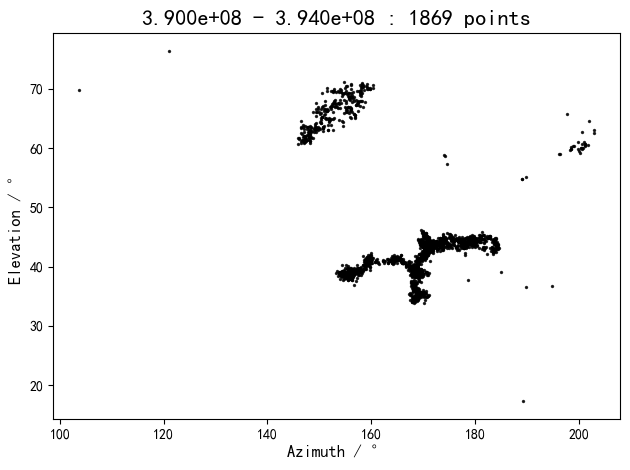

In [210]:
# 绘制二维结果
start_loc = 3.9e8
end_loc = 3.94e8
# 对2d结果进行过滤筛选
filtered_result = two_d_result[
    (abs(two_d_result['t123']) < 1) &  
    (abs(two_d_result['Rcorr']) > 0.4) &  
    (two_d_result['Start_loc'] < end_loc) & 
    (two_d_result['Start_loc'] > start_loc) & 
    (two_d_result['Elevation'] < 80) 
]
# 绘制图像
plot_2d_result(filtered_result,start_loc, end_loc)

In [211]:
# 分析梯级间隔
cal_step_interval(filtered_result,start_loc,end_loc)

最大的间隔位于: 392066376
时间间隔大于3000的个数有：405
信号位置 390000000.0-394000000.0 阶段的时间间隔分布情况：
                 0
count  405.000000
mean    33.227062
std     17.076390
min     15.125000
25%     20.265000
50%     28.800000
75%     40.590000
max    116.690000


In [212]:
# 分析梯级的持续时间
cal_step_duration(filtered_result,start_loc,end_loc)

信号位置 390000000.0-394000000.0 阶段的梯级持续时间分布情况：
                 0
count  404.000000
mean    49.151386
std     26.237097
min     15.145000
25%     30.327500
50%     42.785000
75%     62.646250
max    159.690000


In [213]:
# 计算梯级步长
cal_step_distances(filtered_result,filtered_3d_result,start_loc,end_loc,epsilon=50,min_samples=3)

信号位置 390000000.0-394000000.0 阶段的梯级步长分布情况：
                 0
count    7.000000
mean    53.420288
std     63.523932
min      8.221543
25%     14.772653
50%     26.145449
75%     63.888635
max    182.252446


### 4000-5500高度

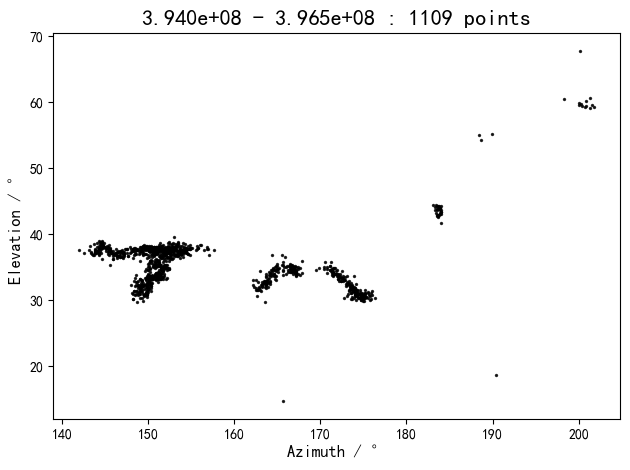

In [214]:
# 选出负先导数据
start_loc = 3.94e8
end_loc = 3.965e8
# 对2d结果进行过滤筛选
filtered_result = two_d_result[
    (abs(two_d_result['t123']) < 1) &  
    (abs(two_d_result['Rcorr']) > 0.4) &  
    (two_d_result['Start_loc'] < end_loc) & 
    (two_d_result['Start_loc'] > start_loc) & 
    (two_d_result['Elevation'] < 80) 
]
# 绘制图像
plot_2d_result(filtered_result,start_loc, end_loc)

In [215]:
# 分析梯级间隔
cal_step_interval(filtered_result,start_loc,end_loc)

最大的间隔位于: 394144429
时间间隔大于3000的个数有：268
信号位置 394000000.0-396500000.0 阶段的时间间隔分布情况：
                 0
count  268.000000
mean    29.838265
std     13.580329
min     15.095000
25%     20.000000
50%     25.550000
75%     36.700000
max     92.110000


In [216]:
# 分析梯级的持续时间
cal_step_duration(filtered_result,start_loc,end_loc)

信号位置 394000000.0-396500000.0 阶段的梯级持续时间分布情况：
                 0
count  267.000000
mean    46.534551
std     23.168137
min     15.095000
25%     29.640000
50%     41.725000
75%     57.425000
max    128.950000


In [217]:
# 计算梯级步长
cal_step_distances(filtered_result,filtered_3d_result,start_loc,end_loc,epsilon=50,min_samples=3)

信号位置 394000000.0-396500000.0 阶段的梯级步长分布情况：
                0
count   1.000000
mean   18.182061
std          NaN
min    18.182061
25%    18.182061
50%    18.182061
75%    18.182061
max    18.182061


### 2500-4000 高度

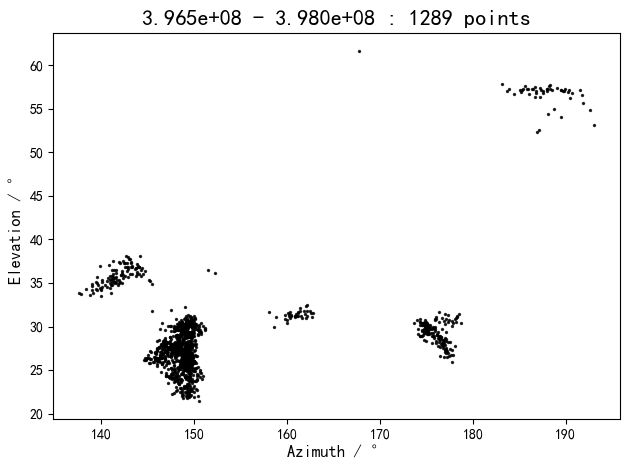

In [218]:
# 绘制二维结果
start_loc = 3.965e8
end_loc = 3.98e8
# 对2d结果进行过滤筛选
filtered_result = two_d_result[
    (abs(two_d_result['t123']) < 1) &  
    (abs(two_d_result['Rcorr']) > 0.4) &  
    (two_d_result['Start_loc'] < end_loc) & 
    (two_d_result['Start_loc'] > start_loc) & 
    (two_d_result['Elevation'] < 80) 
]
# 绘制图像
plot_2d_result(filtered_result,start_loc, end_loc)

In [219]:
# 分析梯级间隔
cal_step_interval(filtered_result,start_loc,end_loc)

最大的间隔位于: 396641638
时间间隔大于3000的个数有：93
信号位置 396500000.0-398000000.0 阶段的时间间隔分布情况：
                0
count  93.000000
mean   21.349624
std     6.076499
min    15.105000
25%    16.970000
50%    20.010000
75%    23.915000
max    43.225000


In [220]:
# 分析梯级的持续时间
cal_step_duration(filtered_result,start_loc,end_loc)

信号位置 396500000.0-398000000.0 阶段的梯级持续时间分布情况：
                 0
count   92.000000
mean    76.941359
std     67.775535
min     16.980000
25%     29.795000
50%     55.357500
75%     94.377500
max    401.680000


In [221]:
# 计算梯级步长
cal_step_distances(filtered_result,filtered_3d_result,start_loc,end_loc,epsilon=50,min_samples=3)

信号位置 396500000.0-398000000.0 阶段的梯级步长分布情况：
                0
count  13.000000
mean   44.589695
std    20.831107
min    12.456577
25%    35.516424
50%    40.775895
75%    55.760293
max    87.940189


### 1000-2500 高度

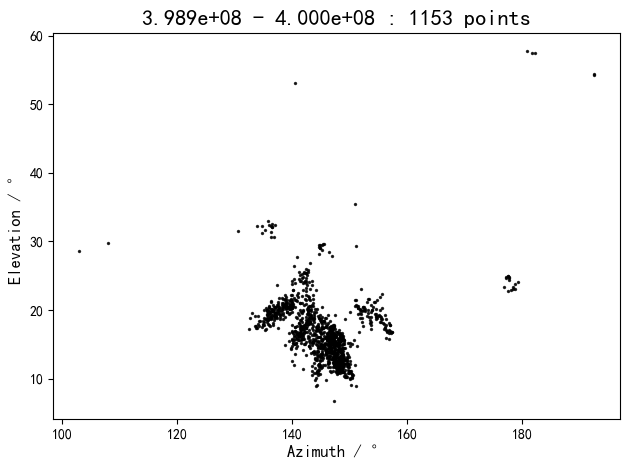

In [222]:
# 绘制二维结果
start_loc = 3.989e8
end_loc = 4e8
# 对2d结果进行过滤筛选
filtered_result = two_d_result[
    (abs(two_d_result['t123']) < 1) &  
    (abs(two_d_result['Rcorr']) > 0.4) &  
    (two_d_result['Start_loc'] < end_loc) & 
    (two_d_result['Start_loc'] > start_loc) & 
    (two_d_result['Elevation'] < 80) 
]
# 绘制图像
plot_2d_result(filtered_result,start_loc, end_loc)

In [223]:
# 分析梯级间隔
cal_step_interval(filtered_result,start_loc,end_loc)

最大的间隔位于: 399329320
时间间隔大于3000的个数有：31
信号位置 398900000.0-400000000.0 阶段的时间间隔分布情况：
                0
count  31.000000
mean   18.029839
std     3.238170
min    15.100000
25%    15.802500
50%    16.305000
75%    19.557500
max    27.260000


In [224]:
# 分析梯级的持续时间
cal_step_duration(filtered_result,start_loc,end_loc)

信号位置 398900000.0-400000000.0 阶段的梯级持续时间分布情况：
                 0
count   30.000000
mean   180.985000
std    154.107338
min     21.710000
25%     57.535000
50%    141.252500
75%    262.427500
max    505.330000


In [225]:
# 计算梯级步长
cal_step_distances(filtered_result,filtered_3d_result,start_loc,end_loc,epsilon=50,min_samples=3)

信号位置 398900000.0-400000000.0 阶段的梯级步长分布情况：
                0
count   1.000000
mean   15.900385
std          NaN
min    15.900385
25%    15.900385
50%    15.900385
75%    15.900385
max    15.900385


### 3.2 计算负先导的间隔

### 500-2000

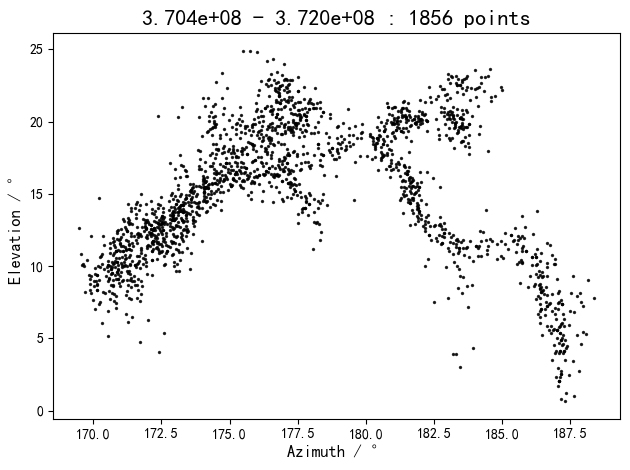

In [276]:
# 绘制二维结果
start_loc = 3.704e8
end_loc = 3.72e8
# 对2d结果进行过滤筛选
filtered_result = two_d_result[
    (abs(two_d_result['t123']) < 1) &  
    (abs(two_d_result['Rcorr']) > 0.4) &  
    (two_d_result['Start_loc'] < end_loc) & 
    (two_d_result['Start_loc'] > start_loc) & 
    (two_d_result['Elevation'] < 25)  & 
    (two_d_result['Azimuth'] > 167)  & 
    (two_d_result['Azimuth'] < 190) 
]
# 绘制图像
plot_2d_result(filtered_result,start_loc, end_loc)

In [277]:
# 分析梯级间隔
cal_step_interval(filtered_result,start_loc,end_loc)

最大的间隔位于: 371149737
时间间隔大于3000的个数有：22
信号位置 370400000.0-372000000.0 阶段的时间间隔分布情况：
                0
count  22.000000
mean   17.936818
std     2.434935
min    15.170000
25%    15.923750
50%    17.325000
75%    18.780000
max    24.050000


In [278]:
# 分析梯级的持续时间
cal_step_duration(filtered_result,start_loc,end_loc)

信号位置 370400000.0-372000000.0 阶段的梯级持续时间分布情况：
                  0
count    21.000000
mean    347.533571
std     319.601120
min      32.840000
25%      95.820000
50%     214.865000
75%     472.315000
max    1017.010000


In [285]:
# 计算梯级步长
cal_step_distances(filtered_result,filtered_3d_result,start_loc,end_loc,epsilon=40,min_samples=3)

信号位置 370400000.0-372000000.0 阶段的梯级步长分布情况：
                0
count  10.000000
mean   48.956301
std    16.960422
min    29.202007
25%    38.147482
50%    39.501910
75%    63.993225
max    75.797518


### 2000-3500

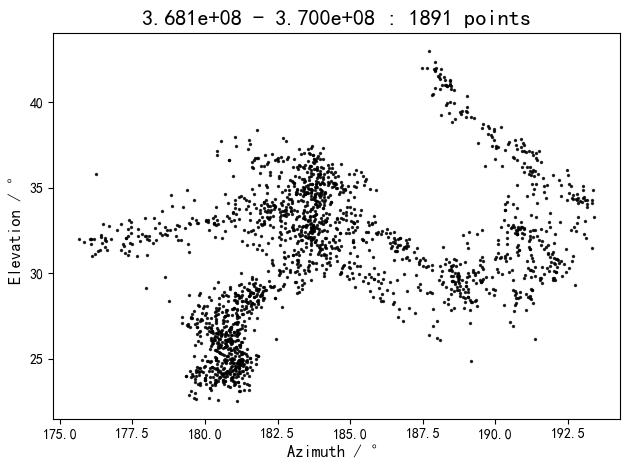

In [286]:
# 绘制二维结果
start_loc = 3.681e8
end_loc = 3.7e8
# 对2d结果进行过滤筛选
filtered_result = two_d_result[
    (abs(two_d_result['t123']) < 1) &  
    (abs(two_d_result['Rcorr']) > 0.4) &  
    (two_d_result['Start_loc'] < end_loc) & 
    (two_d_result['Start_loc'] > start_loc) & 
    (two_d_result['Elevation'] < 43) & 
    (two_d_result['Azimuth'] < 195) 
]
# 绘制图像
plot_2d_result(filtered_result,start_loc, end_loc)

In [287]:
# 分析梯级间隔
cal_step_interval(filtered_result,start_loc,end_loc)

最大的间隔位于: 369148073
时间间隔大于3000的个数有：72
信号位置 368100000.0-370000000.0 阶段的时间间隔分布情况：
                0
count  72.000000
mean   20.756736
std     5.506780
min    15.020000
25%    16.970000
50%    19.330000
75%    23.733750
max    42.485000


In [288]:
# 分析梯级的持续时间
cal_step_duration(filtered_result,start_loc,end_loc)

信号位置 368100000.0-370000000.0 阶段的梯级持续时间分布情况：
                 0
count   71.000000
mean   128.736690
std    119.722606
min     15.615000
25%     38.435000
50%     96.365000
75%    161.747500
max    556.290000


In [289]:
# 计算梯级步长
cal_step_distances(filtered_result,filtered_3d_result,start_loc,end_loc,epsilon=40,min_samples=3)

信号位置 368100000.0-370000000.0 阶段的梯级步长分布情况：
                0
count  32.000000
mean   35.637860
std    16.657476
min     5.765482
25%    25.466201
50%    35.891653
75%    45.126235
max    71.781300


### 3500-5000

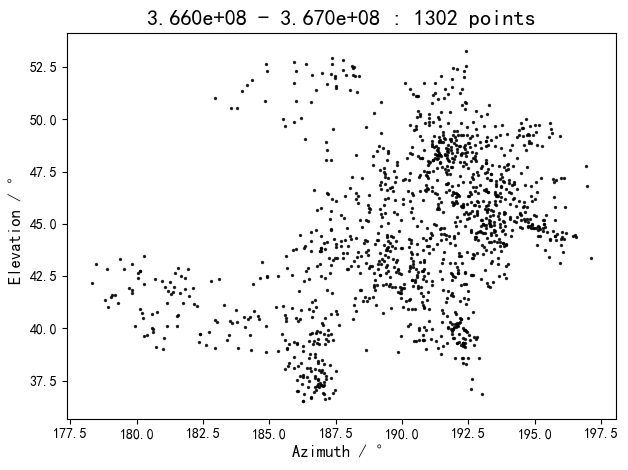

In [291]:
# 绘制二维结果
start_loc = 3.66e8
end_loc = 3.67e8
# 对2d结果进行过滤筛选
filtered_result = two_d_result[
    (abs(two_d_result['t123']) < 1) &  
    (abs(two_d_result['Rcorr']) > 0.4) &  
    (two_d_result['Start_loc'] < end_loc) & 
    (two_d_result['Start_loc'] > start_loc) & 
    (two_d_result['Elevation'] < 55) & 
    (two_d_result['Elevation'] > 36) 
]
# 绘制图像
plot_2d_result(filtered_result,start_loc, end_loc)

In [292]:
# 分析梯级间隔
cal_step_interval(filtered_result,start_loc,end_loc)

最大的间隔位于: 366891515
时间间隔大于3000的个数有：27
信号位置 366000000.0-367000000.0 阶段的时间间隔分布情况：
                0
count  27.000000
mean   17.138519
std     2.211636
min    15.015000
25%    15.910000
50%    16.655000
75%    17.522500
max    26.015000


In [293]:
# 分析梯级的持续时间
cal_step_duration(filtered_result,start_loc,end_loc)

信号位置 366000000.0-367000000.0 阶段的梯级持续时间分布情况：
                 0
count   26.000000
mean   178.058077
std    203.655496
min     15.680000
25%     50.477500
50%    106.137500
75%    208.750000
max    779.975000


In [294]:
# 计算梯级步长
cal_step_distances(filtered_result,filtered_3d_result,start_loc,end_loc,epsilon=40,min_samples=3)

信号位置 366000000.0-367000000.0 阶段的梯级步长分布情况：
                0
count   7.000000
mean   26.816035
std    12.659764
min     4.375582
25%    21.357102
50%    26.052480
75%    37.795134
max    38.979708


### 5000-6500

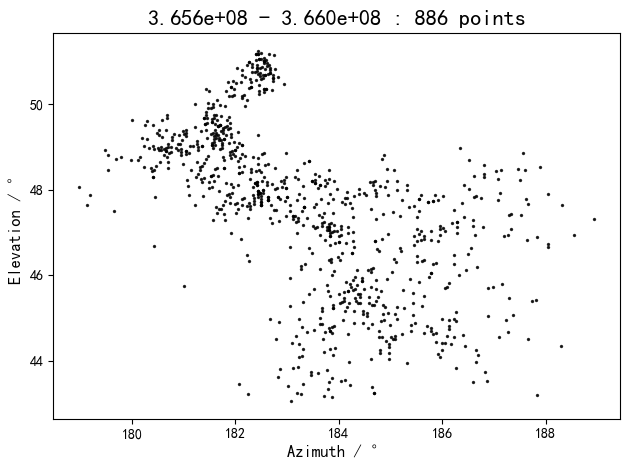

In [340]:
# 绘制二维结果
start_loc = 3.656e8
end_loc = 3.66e8
# 对2d结果进行过滤筛选
filtered_result = two_d_result[
    (abs(two_d_result['t123']) < 1) &  
    (abs(two_d_result['Rcorr']) > 0.4) &  
    (two_d_result['Start_loc'] < end_loc) & 
    (two_d_result['Start_loc'] > start_loc) & 
    (two_d_result['Elevation'] < 51.5) & 
    (two_d_result['Azimuth'] < 189) & 
    (two_d_result['Elevation'] > 43) 
]
# 绘制图像
plot_2d_result(filtered_result,start_loc, end_loc)

In [344]:
# 分析梯级间隔
cal_step_interval(filtered_result,start_loc,end_loc)

最大的间隔位于: 365948133
时间间隔大于3000的个数有：6
信号位置 365600000.0-366000000.0 阶段的时间间隔分布情况：
                0
count   6.000000
mean   24.397500
std     9.625711
min    15.145000
25%    15.733750
50%    24.270000
75%    32.528750
max    34.530000


In [300]:
# 分析梯级的持续时间
cal_step_duration(filtered_result,start_loc,end_loc)

信号位置 365600000.0-366000000.0 阶段的梯级持续时间分布情况：
                 0
count    5.000000
mean    94.876000
std     67.444591
min     47.590000
25%     57.600000
50%     63.790000
75%     93.895000
max    211.505000


In [302]:
# 计算梯级步长
cal_step_distances(filtered_result,filtered_3d_result,start_loc,end_loc,epsilon=40,min_samples=2)

信号位置 365600000.0-366000000.0 阶段的梯级步长分布情况：
                0
count   2.000000
mean   19.184582
std     2.898410
min    17.135097
25%    18.159839
50%    19.184582
75%    20.209325
max    21.234068


## 4. 计算正先导的间隔、步长

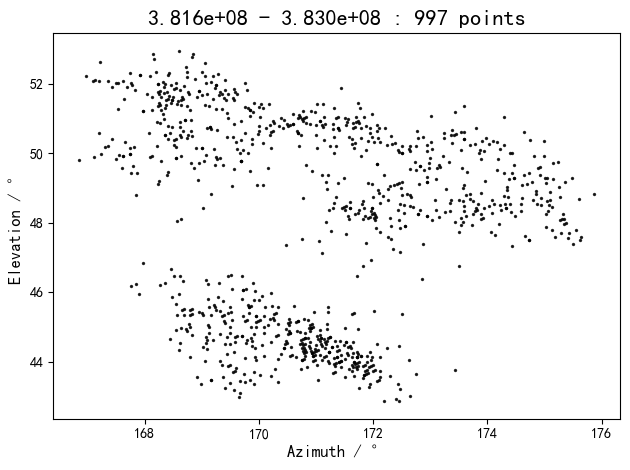

持续时间为：7.0 ms


In [349]:
# 绘制二维结果
start_loc = 3.816e8
end_loc = 3.83e8
# 对2d结果进行过滤筛选
filtered_result = two_d_result[
    (abs(two_d_result['t123']) < 1) &  
    (abs(two_d_result['Rcorr']) > 0.3) &  
    (two_d_result['Start_loc'] < end_loc) & 
    (two_d_result['Start_loc'] > start_loc) & 
    (two_d_result['Elevation'] < 54)  & 
    (two_d_result['Azimuth'] < 178)  & 
    (two_d_result['Elevation'] > 42.5) 
]
# 绘制图像
plot_2d_result(filtered_result,start_loc, end_loc)
print(f'持续时间为：{(end_loc-start_loc)*5/1e6} ms')

In [350]:
# 分析梯级间隔
cal_step_interval(filtered_result,start_loc,end_loc)

最大的间隔位于: 382041486
时间间隔大于3000的个数有：133
信号位置 381600000.0-383000000.0 阶段的时间间隔分布情况：
                 0
count  133.000000
mean    27.346955
std     11.809027
min     15.105000
25%     18.270000
50%     24.430000
75%     33.210000
max     72.790000


In [351]:
# 分析梯级的持续时间
cal_step_duration(filtered_result,start_loc,end_loc)

信号位置 381600000.0-383000000.0 阶段的梯级持续时间分布情况：
                 0
count  132.000000
mean    52.111061
std     29.287836
min     15.230000
25%     31.682500
50%     43.907500
75%     66.850000
max    179.445000


In [352]:
# 计算梯级步长
cal_step_distances(filtered_result,filtered_3d_result,start_loc,end_loc,epsilon=40,min_samples=3)

信号位置 381600000.0-383000000.0 阶段的梯级步长分布情况：
                0
count   6.000000
mean   35.943232
std    27.159369
min     3.407105
25%    22.527153
50%    33.886371
75%    39.734721
max    84.054629


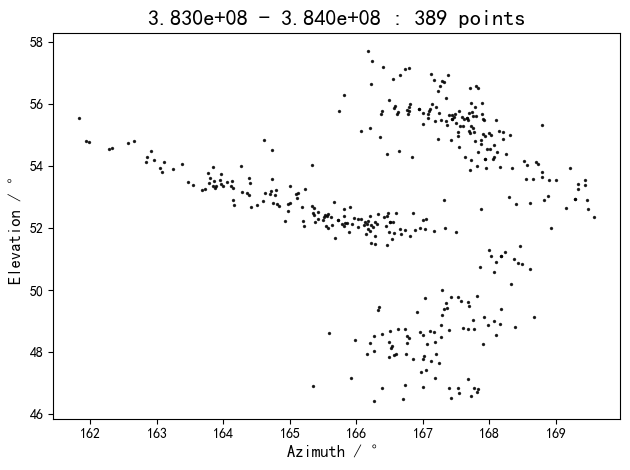

持续时间为：5.0 ms


In [381]:
# 绘制二维结果
start_loc = 3.83e8
end_loc = 3.84e8
# 对2d结果进行过滤筛选
filtered_result = two_d_result[
    (abs(two_d_result['t123']) < 1) &  
    (abs(two_d_result['Rcorr']) > 0.3) &  
    (two_d_result['Start_loc'] < end_loc) & 
    (two_d_result['Start_loc'] > start_loc) & 
    (two_d_result['Elevation'] <65)   &
    (two_d_result['Azimuth'] < 170) 
    # (two_d_result['Elevation'] > 42.5) 
]
# 绘制图像
plot_2d_result(filtered_result,start_loc, end_loc)
print(f'持续时间为：{(end_loc-start_loc)*5/1e6} ms')

In [382]:
# 分析梯级间隔
cal_step_interval(filtered_result,start_loc,end_loc)

最大的间隔位于: 383584764
时间间隔大于3000的个数有：98
信号位置 383000000.0-384000000.0 阶段的时间间隔分布情况：
                 0
count   98.000000
mean    38.455918
std     25.065363
min     15.210000
25%     20.762500
50%     30.910000
75%     48.065000
max    137.040000


In [383]:
# 分析梯级的持续时间
cal_step_duration(filtered_result,start_loc,end_loc)

信号位置 383000000.0-384000000.0 阶段的梯级持续时间分布情况：
                 0
count   97.000000
mean    50.673660
std     29.924896
min     16.380000
25%     26.725000
50%     43.010000
75%     64.930000
max    190.390000


In [390]:
# 计算梯级步长
cal_step_distances(filtered_result,filtered_3d_result,start_loc,end_loc,epsilon=40,min_samples=2)

信号位置 383000000.0-384000000.0 阶段的梯级步长分布情况：
                0
count   6.000000
mean   14.967764
std    14.648324
min     4.818667
25%     7.167866
50%     9.196064
75%    14.517475
max    43.812709


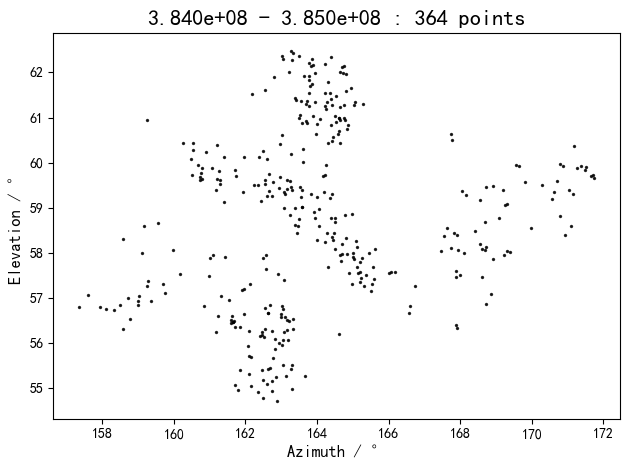

持续时间为：4.85 ms


In [397]:
# 绘制二维结果
start_loc = 3.8403e8
end_loc = 3.85e8
# 对2d结果进行过滤筛选
filtered_result = two_d_result[
    (abs(two_d_result['t123']) < 1) &  
    (abs(two_d_result['Rcorr']) > 0.3) &  
    (two_d_result['Start_loc'] < end_loc) & 
    (two_d_result['Start_loc'] > start_loc) & 
    (two_d_result['Elevation'] < 65) &
    (two_d_result['Azimuth'] < 174) &
    (two_d_result['Azimuth'] > 150) 
]
# 绘制图像
plot_2d_result(filtered_result,start_loc, end_loc)
print(f'持续时间为：{(end_loc-start_loc)*5/1e6} ms')

In [395]:
# 分析梯级间隔
cal_step_interval(filtered_result,start_loc,end_loc)

最大的间隔位于: 384469111
时间间隔大于3000的个数有：92
信号位置 384030000.0-385000000.0 阶段的时间间隔分布情况：
                 0
count   92.000000
mean    38.200489
std     20.712096
min     15.395000
25%     23.170000
50%     32.085000
75%     47.255000
max    135.540000


In [398]:
# 分析梯级的持续时间
cal_step_duration(filtered_result,start_loc,end_loc)

信号位置 384030000.0-385000000.0 阶段的梯级持续时间分布情况：
                 0
count   91.000000
mean    50.478846
std     27.348105
min     15.395000
25%     29.430000
50%     44.115000
75%     65.357500
max    168.115000


In [399]:
# 计算梯级步长
cal_step_distances(filtered_result,filtered_3d_result,start_loc,end_loc,epsilon=40,min_samples=3)

信号位置 384030000.0-385000000.0 阶段的梯级步长分布情况：
               0
count   1.00000
mean   23.37791
std         NaN
min    23.37791
25%    23.37791
50%    23.37791
75%    23.37791
max    23.37791


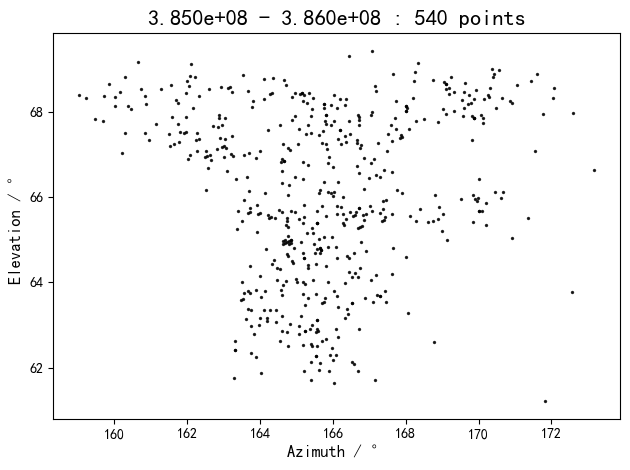

持续时间为：5.0 ms


In [415]:
# 绘制二维结果
start_loc = 3.85e8
end_loc = 3.86e8
# 对2d结果进行过滤筛选
filtered_result = two_d_result[
    (abs(two_d_result['t123']) < 1) &  
    (abs(two_d_result['Rcorr']) > 0.3) &  
    (two_d_result['Start_loc'] < end_loc) & 
    (two_d_result['Start_loc'] > start_loc) & 
    (two_d_result['Elevation'] < 70) & 
    (two_d_result['Elevation'] > 61) & 
    (two_d_result['Azimuth'] < 180) 
]
# 绘制图像
plot_2d_result(filtered_result,start_loc, end_loc)
print(f'持续时间为：{(end_loc-start_loc)*5/1e6} ms')

In [416]:
# 分析梯级间隔
cal_step_interval(filtered_result,start_loc,end_loc)

最大的间隔位于: 385079086
时间间隔大于3000的个数有：80
信号位置 385000000.0-386000000.0 阶段的时间间隔分布情况：
                 0
count   80.000000
mean    41.431875
std     27.429316
min     15.295000
25%     22.482500
50%     31.337500
75%     48.342500
max    121.370000


In [417]:
# 分析梯级的持续时间
cal_step_duration(filtered_result,start_loc,end_loc)

信号位置 385000000.0-386000000.0 阶段的梯级持续时间分布情况：
                 0
count   79.000000
mean    62.674684
std     36.820760
min     16.330000
25%     34.345000
50%     53.720000
75%     80.405000
max    175.300000


In [418]:
# 计算梯级步长
cal_step_distances(filtered_result,filtered_3d_result,start_loc,end_loc,epsilon=40,min_samples=2)

信号位置 385000000.0-386000000.0 阶段的梯级步长分布情况：
                0
count  12.000000
mean   18.850266
std    13.295687
min     3.242786
25%     9.529363
50%    13.729845
75%    32.127524
max    39.153305


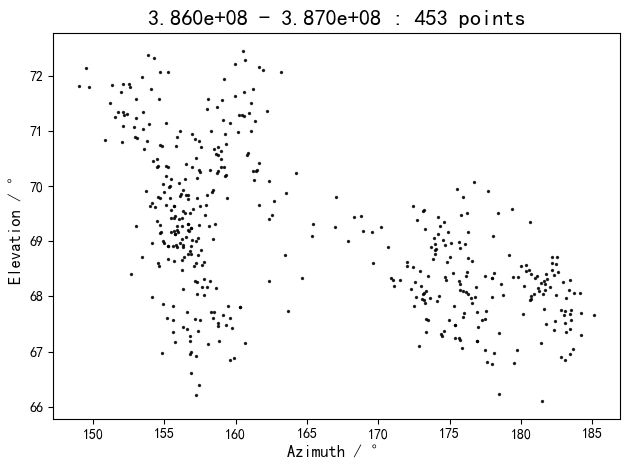

持续时间为：5.0 ms


In [421]:
# 绘制二维结果
start_loc = 3.86e8
end_loc = 3.87e8
# 对2d结果进行过滤筛选
filtered_result = two_d_result[
    (abs(two_d_result['t123']) < 1) &  
    (abs(two_d_result['Rcorr']) > 0.3) &  
    (two_d_result['Start_loc'] < end_loc) & 
    (two_d_result['Start_loc'] > start_loc) & 
    (two_d_result['Elevation'] < 80) & 
    (two_d_result['Elevation'] > 65) 
]
# 绘制图像
plot_2d_result(filtered_result,start_loc, end_loc)
print(f'持续时间为：{(end_loc-start_loc)*5/1e6} ms')

In [422]:
# 分析梯级间隔
cal_step_interval(filtered_result,start_loc,end_loc)

最大的间隔位于: 386090856
时间间隔大于3000的个数有：108
信号位置 386000000.0-387000000.0 阶段的时间间隔分布情况：
                 0
count  108.000000
mean    31.688056
std     16.193340
min     15.010000
25%     18.632500
50%     26.990000
75%     40.070000
max     91.790000


In [423]:
# 分析梯级的持续时间
cal_step_duration(filtered_result,start_loc,end_loc)

信号位置 386000000.0-387000000.0 阶段的梯级持续时间分布情况：
                 0
count  107.000000
mean    45.648692
std     25.396540
min     15.575000
25%     27.405000
50%     41.585000
75%     55.922500
max    169.000000


In [425]:
# 计算梯级步长
cal_step_distances(filtered_result,filtered_3d_result,start_loc,end_loc,epsilon=40,min_samples=2)

信号位置 386000000.0-387000000.0 阶段的梯级步长分布情况：
                0
count   6.000000
mean   13.841043
std    10.706961
min     5.728309
25%     7.215052
50%    10.185637
75%    14.816970
max    34.361073
